In [8]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
import pandas as pd


In [9]:
# I personally don't like scatter, TODO make the one-hot encoder with another function
mnist_data_train = datasets.MNIST(root="./data/", download=True, train=True, transform=ToTensor(), target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
mnist_data_test = datasets.MNIST(root="./data/", download=True,train=False, transform=ToTensor())
data_loader_train = torch.utils.data.DataLoader(mnist_data_train, batch_size=16, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_data_test, batch_size=16, shuffle=True)
print(mnist_data_train[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

## Datasets & DataLoaders

* Datasets and DataLoaders are a Pytorch's way to deal with data.
* Dataset stores the data and it's properties(it must have a `__getitem__` and a `__len__` method) while DataLoader gives an iterator for a Dataset
* In the DataLoader constructor, we can set some properties as the batch_size and shuffle.
* The DataLoader will also allow us to use multiprocessing in the future

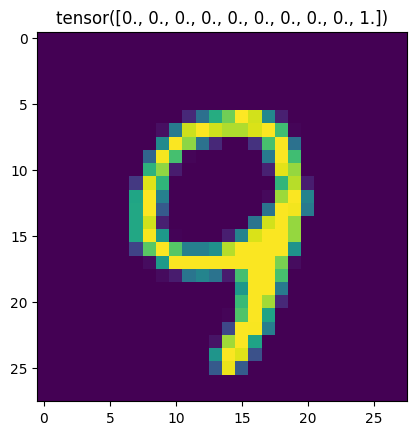

In [10]:
# Using Dataset directly
img, label = mnist_data_train[torch.randint(len(mnist_data_train)-1, size=(1,)).item()]
plt.title(label=label)
plt.imshow(img.squeeze())

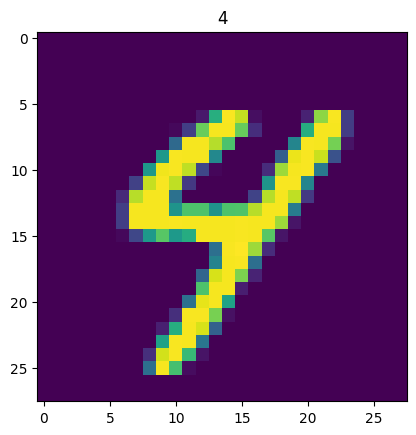

In [11]:
# Using DataLoader

features, labels = next(iter(data_loader_train))
plt.title(label=(labels[0]==1).nonzero(as_tuple=True)[0].item())
plt.imshow(features[0].squeeze())

In [12]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {device}")

Device: cpu


## Neural Network class
Every module is a subclass of nn.Module, every nn.Module subclass has to implement an `__init__()` and a `forward` method.


In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [14]:
model = NeuralNetwork().to(device)
X = torch.rand(1, 28, 28, device=device)
logits= model(X)
pred_prob = nn.Softmax(dim=1)(logits)
y_pred = pred_prob.argmax(1)
print(f"Predict: {y_pred}")

Predict: tensor([4])


In [15]:
# Model parameters
for name, param in model.named_parameters():
    print(f"Layer {name} - values: {param}")

Layer linear_relu_stack.0.weight - values: Parameter containing:
tensor([[ 0.0330,  0.0333,  0.0098,  ..., -0.0195, -0.0350,  0.0309],
        [ 0.0088,  0.0051, -0.0178,  ...,  0.0229,  0.0227,  0.0261],
        [-0.0054, -0.0011, -0.0015,  ..., -0.0114,  0.0019,  0.0273],
        ...,
        [ 0.0278, -0.0301,  0.0329,  ..., -0.0277, -0.0213, -0.0212],
        [ 0.0009,  0.0227, -0.0227,  ...,  0.0309,  0.0202,  0.0238],
        [-0.0136, -0.0291,  0.0336,  ...,  0.0170,  0.0129,  0.0088]],
       requires_grad=True)
Layer linear_relu_stack.0.bias - values: Parameter containing:
tensor([ 3.0652e-03,  1.2184e-02, -1.8588e-02, -7.3463e-03,  7.1099e-03,
         1.2008e-02,  3.3164e-02,  3.5378e-02, -8.9719e-03,  1.6300e-02,
        -1.6666e-02, -7.1762e-03, -2.2060e-03, -3.7772e-05,  3.2818e-02,
        -1.6838e-02,  2.1002e-02,  2.6667e-03, -7.2948e-03, -3.2296e-02,
         5.0562e-03,  1.8730e-02,  5.5449e-03, -1.9935e-02, -3.5239e-02,
        -1.8136e-02, -1.6707e-02, -1.3659e-02,

In [16]:
# Loss function for classification
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Optimization
Optization happens in three steps in the training loop:
* reset the gradients by calling `optimizer.zero_grad()`
* backpropagate the prediction loss using `loss.backward()`. The gradient of the loss for each parameter will be stored
* adjust the parameters using the gradients collected in backpropagation step using `optimizer.step()`


In [32]:
def train_loop(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    for batch, (X, y) in enumerate(data_loader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X) # each batch will have len(X) samples
            print(f"loss: {loss} [{current}/{size}]")

def test_loop(data_loader, model, loss_fn):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0
    with torch.no_grad(): # makes requires_grad = False for all nodes of the computational graph
        for X, y in data_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy {100*correct:0.1f}%, average loss: {test_loss:0.8f}")



In [33]:
epochs = 3 
for t in range(epochs):
    print(f"Epoch {t+1} \n --------------------")
    train_loop(data_loader_train, model, loss_fn, optimizer)
    test_loop(data_loader_test, model, loss_fn)



Epoch 1 
 --------------------
tensor([[-2.4523e-03, -1.2558e-01,  2.7437e-01, -2.5401e-01, -3.7736e-02,
         -2.2795e-01,  5.6953e-01, -1.5014e-01,  1.2078e-01, -5.0079e-02],
        [ 2.8910e-01, -3.0291e-01, -6.6864e-02,  4.8068e-01, -1.2203e-01,
          1.8545e-01,  1.2600e-02, -1.9507e-01,  1.2068e-01, -9.5227e-02],
        [-1.3768e-01,  1.3323e-01,  5.1605e-01,  2.5938e-01, -2.8309e-01,
         -2.8359e-01,  1.6355e-01, -1.0040e-01,  2.4755e-01, -2.5322e-01],
        [ 7.1515e-01, -3.7319e-01,  1.1346e-01,  6.6947e-02, -1.0258e-01,
          9.5811e-02,  1.5946e-01, -2.2176e-01, -2.4146e-02, -2.2528e-01],
        [-1.5742e-01, -6.1493e-02, -3.6646e-02,  2.9116e-02,  1.3314e-01,
         -1.0427e-01, -2.4814e-02,  3.6589e-01,  1.7350e-02,  2.9001e-01],
        [-2.4348e-03, -6.8924e-02,  3.9137e-02,  9.5336e-02,  6.2789e-02,
         -5.9914e-02,  3.2530e-02,  1.9594e-02,  7.6804e-02,  1.2594e-01],
        [ 2.3750e-01, -5.1471e-01,  3.4948e-01, -3.7357e-01,  3.5801e-01,
 

RuntimeError: result type Float can't be cast to the desired output type Long